# Car Classification Model


### Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [3]:
BATCH_SIZE = 10
IMAGE_WIDTH = 1200
IMAGE_HEIGHT = 900
CHANNELS=3
EPOCHS=100

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CarImages",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)

Found 192 files belonging to 3 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [6]:
class_names = dataset.class_names
class_names

['Ford_Explorer', 'Lexus_RX350', 'Toyota_Matrix']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(10, 1200, 900, 3)
[1 1 1 0 0 1 1 2 2 2]


As you can see above, dataset.take(1) is taking first batch of images which inculdes 9 images, and it's shape is tuple and second one is converted into numpy dataset

### Visualize some of the images from our dataset

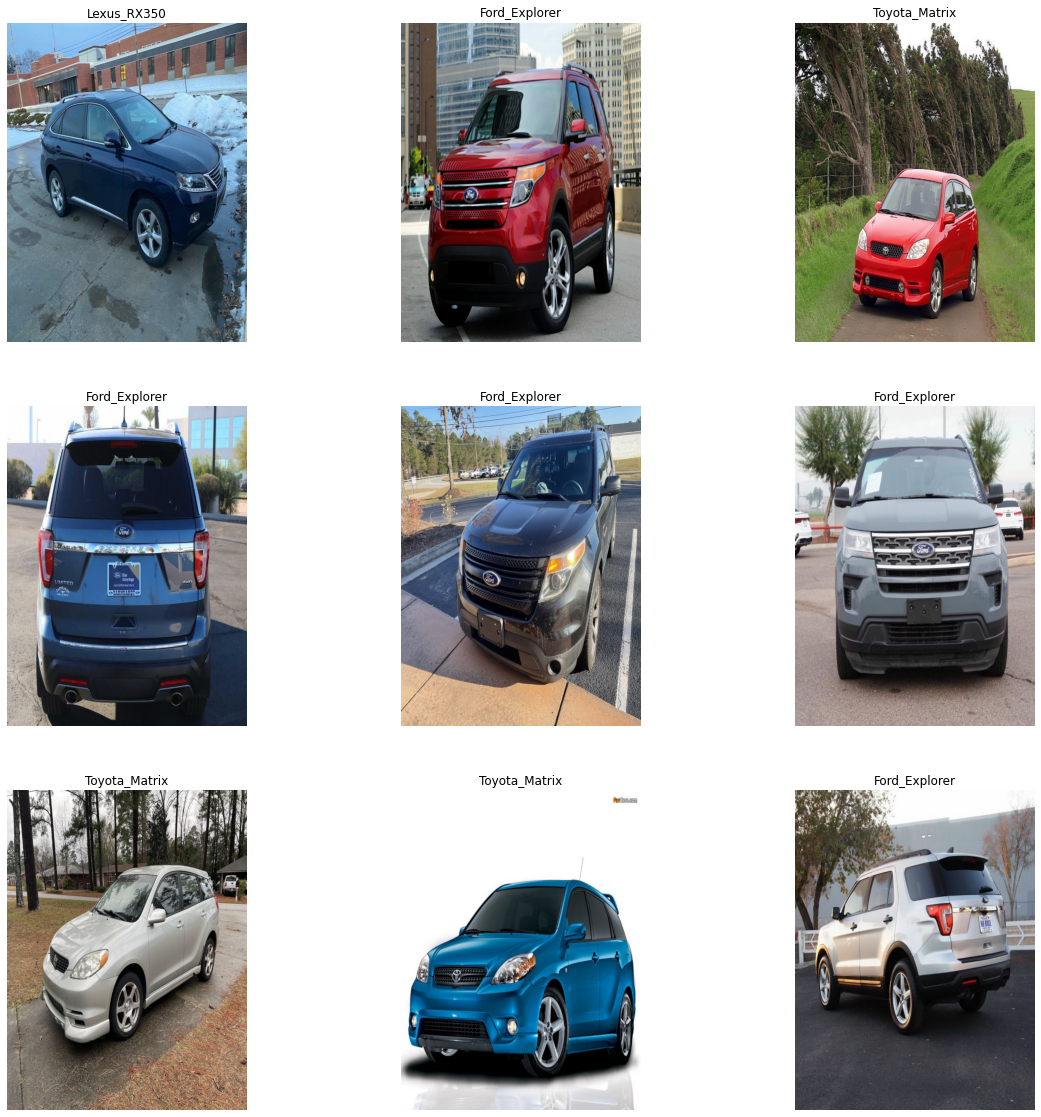

In [9]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i +1  )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(dataset)

20

In [12]:
len(train_ds) 

16

In [13]:
len(val_ds)

2

In [14]:
len(test_ds)

2

### Cache, Shuffle, and Prefetch the Dataset

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
   layers.experimental.preprocessing.RandomZoom(.5, .2),
    
])

#### Applying Data Augmentation to Train Dataset

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [19]:
input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (10, 1200, 900, 3)        0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1200, 900, 3)      0         
_________________________________________________________________
conv2d (Conv2D)              (10, 1198, 898, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (10, 599, 449, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (10, 597, 447, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (10, 298, 223, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (10, 296, 221, 64)       

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)
model.save(f"../train_model/carTrainedModel")

Epoch 1/100
16/16 [==============================] - 116s 7s/step - loss: 1.0864 - accuracy: 0.4474 - val_loss: 1.0915 - val_accuracy: 0.4500
Epoch 2/100
16/16 [==============================] - 102s 6s/step - loss: 1.0879 - accuracy: 0.4276 - val_loss: 1.1363 - val_accuracy: 0.3000
Epoch 3/100
16/16 [==============================] - 106s 6s/step - loss: 1.0962 - accuracy: 0.4539 - val_loss: 1.0868 - val_accuracy: 0.3000
Epoch 4/100
16/16 [==============================] - 99s 6s/step - loss: 1.0782 - accuracy: 0.4539 - val_loss: 1.0955 - val_accuracy: 0.3000
Epoch 5/100
16/16 [==============================] - 98s 6s/step - loss: 1.0683 - accuracy: 0.4539 - val_loss: 1.1097 - val_accuracy: 0.3000
Epoch 6/100
16/16 [==============================] - 110s 7s/step - loss: 1.0700 - accuracy: 0.4539 - val_loss: 1.0970 - val_accuracy: 0.3000
Epoch 7/100
16/16 [==============================] - 101s 6s/step - loss: 1.0613 - accuracy: 0.4539 - val_loss: 1.1030 - val_accuracy: 0.3000
Epoch 8/

16/16 [==============================] - 89s 5s/step - loss: 0.6809 - accuracy: 0.6382 - val_loss: 0.6148 - val_accuracy: 0.7500
Epoch 59/100
16/16 [==============================] - 89s 6s/step - loss: 0.6758 - accuracy: 0.7171 - val_loss: 0.6693 - val_accuracy: 0.8500
Epoch 60/100
16/16 [==============================] - 88s 5s/step - loss: 0.7182 - accuracy: 0.6382 - val_loss: 0.6820 - val_accuracy: 0.7000
Epoch 61/100
16/16 [==============================] - 89s 5s/step - loss: 0.7496 - accuracy: 0.6776 - val_loss: 0.7432 - val_accuracy: 0.6000
Epoch 62/100
16/16 [==============================] - 88s 6s/step - loss: 0.7624 - accuracy: 0.6053 - val_loss: 0.5965 - val_accuracy: 0.8500
Epoch 63/100
16/16 [==============================] - 88s 5s/step - loss: 0.7053 - accuracy: 0.7237 - val_loss: 0.6152 - val_accuracy: 0.8500
Epoch 64/100
16/16 [==============================] - 90s 5s/step - loss: 0.6600 - accuracy: 0.6842 - val_loss: 0.5912 - val_accuracy: 0.7500
Epoch 65/100
16/16 

2022-01-30 12:19:41.468056: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../train_model/carTrainedModel/assets


In [ ]:
scores = model.evaluate(test_ds)

**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [ ]:
scores

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
history.params

In [ ]:
history.history.keys()

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model


In [ ]:
model.save(f"../train_model/carTrainedModel")